In [ ]:
!pip install tensorflow_probability

In [1]:
import os
import random
import math
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, concatenate, Conv2D, MaxPooling2D
import tensorflow.keras.losses as kls
#import tensorflow_probability as tfp

from libs.utils import *
from libs.generate_boxes import  *

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [10]:
class Actor(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, output_size):
        super(Actor, self).__init__()
        
        l1, b1, k1 = state_size
        self.state_size = (l1*b1*k1,)
        self.case_dnn1 = Dense(64, activation='relu', input_shape=self.state_size)
        self.case_dnn2 = Dense(64, activation='relu')
        
        l2, b2, k2 = selected_size
        self.selected_size = (l2*b2*k2,)
        self.select_dnn1 = Dense(64, activation='relu', input_shape=self.selected_size)
        self.select_dnn2 = Dense(64, activation='relu')
        
        l3, b3, k3 = remain_size
        self.remain_size = (l3*b3*k3,)
        self.remain_dnn1 = Dense(128, activation='relu', input_shape=self.remain_size)
        self.remain_dnn2 = Dense(128, activation='relu')
        
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(128, activation='relu')
        self.out = Dense(output_size, activation='softmax')
        
    def call(self, cb_list):
        c, s, r = cb_list[0], cb_list[1], cb_list[2]
        c = tf.reshape(c, [-1, self.state_size[0]])
        s = tf.reshape(s, [-1, self.selected_size[0]])
        r = tf.reshape(r, [-1, self.remain_size[0]])
        
        c = self.case_dnn1(c)
        c = self.case_dnn2(c)
        
        s = self.select_dnn1(s)
        s = self.select_dnn2(s)
        
        r = self.remain_dnn1(r)
        r = self.remain_dnn2(r)
        
        x = concatenate([c,s,r])
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        q = self.out(x)
        return q

In [11]:
class Critic(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, output_size):
        super(Critic, self).__init__()
        
        l1, b1, k1 = state_size
        self.state_size = (l1*b1*k1,)
        self.case_dnn1 = Dense(64, activation='relu', input_shape=self.state_size)
        self.case_dnn2 = Dense(64, activation='relu')
        
        l2, b2, k2 = selected_size
        self.selected_size = (l2*b2*k2,)
        self.select_dnn1 = Dense(64, activation='relu', input_shape=self.selected_size)
        self.select_dnn2 = Dense(64, activation='relu')
        
        l3, b3, k3 = remain_size
        self.remain_size = (l3*b3*k3,)
        self.remain_dnn1 = Dense(128, activation='relu', input_shape=self.remain_size)
        self.remain_dnn2 = Dense(128, activation='relu')
        
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.d3 = Dense(128, activation='relu')
        self.out = Dense(output_size, activation='softmax')
        
    def call(self, cb_list):
        c, s, r = cb_list[0], cb_list[1], cb_list[2]
        c = tf.reshape(c, [-1, self.state_size[0]])
        s = tf.reshape(s, [-1, self.selected_size[0]])
        r = tf.reshape(r, [-1, self.remain_size[0]])
        
        c = self.case_dnn1(c)
        c = self.case_dnn2(c)
        
        s = self.select_dnn1(s)
        s = self.select_dnn2(s)
        
        r = self.remain_dnn1(r)
        r = self.remain_dnn2(r)
        
        x = concatenate([c,s,r])
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        q = self.out(x)
        return q

In [21]:
class PPO_Agent():
    def __init__(self, L=20, B=20, H=20, n_remains=5, lr=1e-8, exp_steps=500,
                train_st = 200, memory_len = 500):
        self.state_size = (L,B,1)
        self.selected_size = (L,B,2)
        self.remain_size = (L,B,n_remains)
        self.output_size = 1
        
        self.discount_factor = 0.99
        self.learning_rate = lr #1e-8 #1e-4
        self.exploration_steps = exp_steps
        self.batch_size = 32
        self.train_start = train_st
        self.beta = 0.2
        self.clip_pram = 0.2
        self.memory = deque(maxlen=memory_len)
        self.gamma = 0.9
        self.actor = Actor(self.state_size, self.selected_size, self.remain_size, self.output_size)
        self.critic = Critic(self.state_size, self.selected_size, self.remain_size, self.output_size)
        self.actor_optimizer = Adam(self.learning_rate)
        self.critic_optimizer = Adam(self.learning_rate)
        self.avg_actor_loss = 0
        self.avg_critic_loss = 0
        
    def get_action(self, state, loaded_mh_c, r_boxes):
        if len(self.memory) < self.train_start:
            random_action = random.randrange(len(state))
            return random_action
        else:
            q_values = self.actor([state, loaded_mh_c, r_boxes])
            argmax_idx = np.where(q_values == tf.math.reduce_max(q_values))
            action_idx = argmax_idx[0][0]
            return action_idx
        
    def append_sample(self, history, load, remain_size, load_size, reward, last, next_history, next_load, next_remain_size, next_load_size):
        self.memory.append(( history, load, remain_size, load_size, reward, last, next_history, next_load, next_remain_size, next_load_size))
        
    def actor_loss_temp(self, probs, actions, adv, old_probs, closs):
        probability = probs
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability, tf.math.log(probability))))
        sur1 = []
        sur2 = []
        
        for pb, t, op in zip(probability, adv, old_probs):
            t = tf.constant(t)
            op = tf.constant(op)
            ratio = tf.math.divide(pb, op)
            s1 = tf.math.multiply(ratio, t)
            s2 = tf.math.multiply(tf.clip_by_value(ratio, 1.0-self.clip_pram, 1.0 + self.clip_pram), t)
            sur1.append(s1)
            sur2.append(s2)
        
        sr1 = tf.stack(sur1)
        sr2 = tf.stack(sur2)
        
        loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) - closs + 0.001 * entropy)
        return loss
    
    def get_actor_loss(self, discnt_rewards, a):
        err = tf.abs(discnt_rewards - a)
        quad = tf.clip_by_value(err, 0.0, 1.0)
        linear = err - quad
        loss = tf.reduce_mean(0.5 * tf.square(quad) + linear)
        return loss
        
        #return 0.5 * kls.mean_squared_error(discnt_rewards, a)
    
    def get_critic_loss(self, discnt_rewards, v):
        err = tf.abs(discnt_rewards - v)
        quad = tf.clip_by_value(err, 0.0, 1.0)
        linear = err - quad
        loss = tf.reduce_mean(0.5 * tf.square(quad) + linear)
        return loss
        #return 0.5 * kls.mean_squared_error(discnt_rewards, v)
    
    def train_model(self):
        batch = random.sample(self.memory, self.batch_size)
        
        history = np.array([sample[0] for sample in batch])
        load = np.array([sample[1] for sample in batch])
        remain_size = np.array([sample[2] for sample in batch])
        load_size = np.array([sample[3] for sample in batch])
        reward = np.array([sample[4] for sample in batch])
        dones = np.array([sample[5] for sample in batch])
        next_history = [sample[6] for sample in batch] 
        next_load = [sample[7] for sample in batch]
        next_remain_size = [sample[8] for sample in batch] 
        next_load_size = [sample[9] for sample in batch] 
        
        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            actor = self.actor([history, load, remain_size])
            value = self.critic([history, load, remain_size])
            targets = []
            for i in range(self.batch_size):
                next_value = agent.critic([next_history[i], next_load[i], next_remain_size[i]])
                t_max_q = tf.math.reduce_max(next_value)
                t = [(1- 0.75)*reward[i] + (1 - dones[i]) *0.75*t_max_q]
                targets.append(t)
            actor_loss = self.get_actor_loss(targets, actor)
            critic_loss = self.get_critic_loss(targets, value)
            self.avg_actor_loss += actor_loss.numpy()
            self.avg_critic_loss += critic_loss.numpy()
                
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

In [16]:
num_episode = 500
global_step = 0
allow_skip = False
tr_l, h_fill, tr_r, avg_actor_loss_l, avg_critic_loss_l, history_eps, used_boxes_eps = [],[],[],[],[],[],[]
N_MDD = 7
K = 4
n_candidates = 4

boxes_multi1 = [np.array([[20, 20,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20, 20,  4],
         [20, 20,  4],
         [20, 20,  4]])]
gt_pos1 = [np.array([[ 0,  0,  0],
         [ 0,  0,  4],
         [ 0,  4,  4],
         [ 0,  8,  4],
         [ 0, 12,  4],
         [ 0, 16,  4],
         [ 0,  0,  8],
         [ 0,  0, 12],
         [ 0,  0, 16]])]

boxes_multi2 = [np.array([[20, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [10, 20,  5],
        [10, 20,  5],
        [20, 20,  5]])]

gt_pos2 = [np.array([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 4,  0,  5],
        [ 8,  0,  5],
        [12,  0,  5],
        [16,  0,  5],
        [ 0,  0, 10],
        [10,  0, 10],
        [ 0,  0, 15]])]

num_max_boxes = max(len(boxes_multi1[0]), len(boxes_multi2[0]))
num_max_remain = num_max_boxes
print('num_max_boxes',num_max_boxes,'num_max_remain',num_max_remain)

env=Bpp3DEnv()
agent = PPO_Agent(L=20, B=20, H=20, n_remains=num_max_remain, lr=1e-4, exp_steps=900,
                train_st=500, memory_len=1000)

num_max_boxes 9 num_max_remain 9


In [17]:
for e in range(num_episode):
    st=time.time()
    
    if e%2 == 1: 
        boxes_multi,gt_pos = boxes_multi1.copy(), gt_pos1.copy()
    else: 
        boxes_multi,gt_pos = boxes_multi2.copy(), gt_pos2.copy()
    
    env.reset()
    done = False
    step = 0
    
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    next_history, next_load, next_remain_size, next_load_size = [],[],[],[]
    used_boxes, pred_pos = [],[]
    
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy()

    while not done:
        state = env.container.copy()
        state_h = env.update_h().copy()
        step += 1
        
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)
        s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c = get_selected_location(s_order, state) 
        loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth, env.height) for s_loc in s_loc_c] ) # 3D -> 2D
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(s_loc_c), r_boxes, num_max_remain, K, loading_size_c, env.height)
        
        s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_state, in_r_boxes, in_loading =\
            get_unique(s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_state, in_r_boxes, in_loading)
        
        if len(s_loc_c) == 1:
            action_idx = 0
        else:
            action_idx = agent.get_action(in_state, loaded_mh_c, in_r_boxes)
        
        env.convert_state(next_cube_c[action_idx]) 
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = loading_size_c[action_idx]
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
        used_boxes = used_boxes + loading_size_c[action_idx]
        pred_pos = pred_pos + loading_pos_c[action_idx]  
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0:
            done = True

        if len(s_loc_c) != 1 or done:
            history.append(in_state[action_idx])
            h_load.append(loaded_mh_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])
            
            next_state = env.container.copy()
            next_state_h = env.container_h.copy() 
            if done:
                in_next_history = next_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2))
                in_next_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_next_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k)
                s_order = get_selected_order(selected, k)
                s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c  =\
                    get_selected_location(s_order, next_state)
                loaded_mh_c = np.array( [get_loaded_mh(s_loc, env.length, env.breadth, env.height) for s_loc in s_loc_c] )
                in_next_history, in_next_remains, in_next_loading =\
                    raw2input(next_state_h, len(s_loc_c), r_boxes, num_max_remain,  K, loading_size_c, env.height)

            s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_next_history, in_next_remains, in_next_loading =\
                get_unique(s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_next_history, in_next_remains, in_next_loading)

            next_history.append(in_next_history)
            next_load.append(loaded_mh_c)
            next_remain_size.append(in_next_remains)
            next_load_size.append(in_next_loading)
                
        if done:
            avg_tr = 0 if len(tr_r)==0 else np.mean(tr_r)
            terminal_reward = env.terminal_reward()
            tr_l.append(terminal_reward)
            h_fill.append(env.terminal_reward())
            tr_r.append(env.terminal_reward())
            
            a_repeate = 6 if env.terminal_reward() ==1.0 else 1
            is_last = False 
            N = len(history)
            for i in range(N):
                if i == N-1: is_last=True
                if is_last:
                    delta = 
                else: 
                    delta = 
                reward=(0.99**(N-i-1))*terminal_reward
                for a in range(a_repeate):
                    agent.append_sample(history[i], h_load[i], h_remain_size[i], h_load_size[i], reward, is_last,
                                        next_history[i], next_load[i], next_remain_size[i], next_load_size[i])
        
        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            avg_actor_loss_l.append(agent.avg_actor_loss)
            avg_critic_loss_l.append(agent.avg_critic_loss)
    #print(agent.avg_actor_loss)
    log = "=====episode: {:5d} | ".format(e)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "reward(): {:.3f}, {:.3f}| ".format(env.terminal_reward(), terminal_reward)
    log += "avg actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "avg critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

=====episode:     0 | memory length:     3 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.944
=====episode:     1 | memory length:     5 | reward(): 0.760, 0.760| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.798
=====episode:     2 | memory length:     8 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.932
=====episode:     3 | memory length:    10 | reward(): 0.720, 0.720| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.796
=====episode:     4 | memory length:    13 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.980
=====episode:     5 | memory length:    15 | reward(): 0.720, 0.720| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.868
=====episode:     6 | memory length:    18 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 1.003
=====episode:     7 | memory length:    20 | reward(): 0.800, 

=====episode:    62 | memory length:   217 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.881
=====episode:    63 | memory length:   220 | reward(): 0.600, 0.600| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.877
=====episode:    64 | memory length:   223 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.951
=====episode:    65 | memory length:   225 | reward(): 0.800, 0.800| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.895
=====episode:    66 | memory length:   228 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.909
=====episode:    67 | memory length:   230 | reward(): 0.760, 0.760| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.823
=====episode:    68 | memory length:   233 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.996
=====episode:    69 | memory length:   236 | reward(): 0.600, 

=====episode:   124 | memory length:   420 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.948
=====episode:   125 | memory length:   422 | reward(): 0.800, 0.800| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.950
=====episode:   126 | memory length:   425 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.995
=====episode:   127 | memory length:   428 | reward(): 0.600, 0.600| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.936
=====episode:   128 | memory length:   430 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.910
=====episode:   129 | memory length:   433 | reward(): 0.600, 0.600| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.887
=====episode:   130 | memory length:   435 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.888
=====episode:   131 | memory length:   453 | reward(): 1.000, 

=====episode:   186 | memory length:   606 | reward(): 0.750, 0.750| avg actor loss : 0.083621 avg critic loss : 0.083621 time: 2.192
=====episode:   187 | memory length:   608 | reward(): 0.800, 0.800| avg actor loss : 0.122054 avg critic loss : 0.122054 time: 1.756
=====episode:   188 | memory length:   611 | reward(): 0.750, 0.750| avg actor loss : 0.148011 avg critic loss : 0.148011 time: 2.277
=====episode:   189 | memory length:   613 | reward(): 0.800, 0.800| avg actor loss : 0.151532 avg critic loss : 0.151532 time: 1.661
=====episode:   190 | memory length:   616 | reward(): 0.750, 0.750| avg actor loss : 0.131248 avg critic loss : 0.131248 time: 2.108
=====episode:   191 | memory length:   618 | reward(): 0.800, 0.800| avg actor loss : 0.108756 avg critic loss : 0.108756 time: 1.638
=====episode:   192 | memory length:   621 | reward(): 0.750, 0.750| avg actor loss : 0.116027 avg critic loss : 0.116027 time: 2.158
=====episode:   193 | memory length:   623 | reward(): 0.800, 

=====episode:   248 | memory length:   761 | reward(): 0.750, 0.750| avg actor loss : 0.108552 avg critic loss : 0.108552 time: 2.306
=====episode:   249 | memory length:   763 | reward(): 0.800, 0.800| avg actor loss : 0.122603 avg critic loss : 0.122603 time: 1.633
=====episode:   250 | memory length:   766 | reward(): 0.750, 0.750| avg actor loss : 0.126379 avg critic loss : 0.126379 time: 2.133
=====episode:   251 | memory length:   768 | reward(): 0.800, 0.800| avg actor loss : 0.137795 avg critic loss : 0.137795 time: 1.650
=====episode:   252 | memory length:   771 | reward(): 0.750, 0.750| avg actor loss : 0.121722 avg critic loss : 0.121722 time: 2.169
=====episode:   253 | memory length:   773 | reward(): 0.800, 0.800| avg actor loss : 0.129862 avg critic loss : 0.129862 time: 1.652
=====episode:   254 | memory length:   776 | reward(): 0.750, 0.750| avg actor loss : 0.133891 avg critic loss : 0.133891 time: 2.142
=====episode:   255 | memory length:   778 | reward(): 0.800, 

=====episode:   310 | memory length:   916 | reward(): 0.750, 0.750| avg actor loss : 0.123219 avg critic loss : 0.123219 time: 2.258
=====episode:   311 | memory length:   918 | reward(): 0.800, 0.800| avg actor loss : 0.141959 avg critic loss : 0.141959 time: 1.668
=====episode:   312 | memory length:   921 | reward(): 0.750, 0.750| avg actor loss : 0.114936 avg critic loss : 0.114936 time: 2.194
=====episode:   313 | memory length:   923 | reward(): 0.800, 0.800| avg actor loss : 0.112062 avg critic loss : 0.112062 time: 1.701
=====episode:   314 | memory length:   926 | reward(): 0.750, 0.750| avg actor loss : 0.137427 avg critic loss : 0.137427 time: 2.153
=====episode:   315 | memory length:   928 | reward(): 0.800, 0.800| avg actor loss : 0.114757 avg critic loss : 0.114757 time: 1.713
=====episode:   316 | memory length:   931 | reward(): 0.750, 0.750| avg actor loss : 0.127674 avg critic loss : 0.127674 time: 2.311
=====episode:   317 | memory length:   933 | reward(): 0.800, 

=====episode:   372 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.109605 avg critic loss : 0.109605 time: 2.185
=====episode:   373 | memory length:  1000 | reward(): 0.800, 0.800| avg actor loss : 0.130663 avg critic loss : 0.130663 time: 1.698
=====episode:   374 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.143761 avg critic loss : 0.143761 time: 2.196
=====episode:   375 | memory length:  1000 | reward(): 0.800, 0.800| avg actor loss : 0.122101 avg critic loss : 0.122101 time: 1.641
=====episode:   376 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.102251 avg critic loss : 0.102251 time: 2.180
=====episode:   377 | memory length:  1000 | reward(): 0.800, 0.800| avg actor loss : 0.157288 avg critic loss : 0.157288 time: 1.723
=====episode:   378 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.152039 avg critic loss : 0.152039 time: 2.177
=====episode:   379 | memory length:  1000 | reward(): 0.800, 

=====episode:   434 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.118830 avg critic loss : 0.118830 time: 2.150
=====episode:   435 | memory length:  1000 | reward(): 0.800, 0.800| avg actor loss : 0.112062 avg critic loss : 0.112062 time: 1.656
=====episode:   436 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.118800 avg critic loss : 0.118800 time: 2.143
=====episode:   437 | memory length:  1000 | reward(): 0.800, 0.800| avg actor loss : 0.086385 avg critic loss : 0.086385 time: 1.695
=====episode:   438 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.134270 avg critic loss : 0.134270 time: 2.176
=====episode:   439 | memory length:  1000 | reward(): 0.800, 0.800| avg actor loss : 0.095932 avg critic loss : 0.095932 time: 1.800
=====episode:   440 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.150977 avg critic loss : 0.150977 time: 2.282
=====episode:   441 | memory length:  1000 | reward(): 0.800, 

=====episode:   496 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.113063 avg critic loss : 0.113063 time: 2.206
=====episode:   497 | memory length:  1000 | reward(): 0.800, 0.800| avg actor loss : 0.127755 avg critic loss : 0.127755 time: 1.664
=====episode:   498 | memory length:  1000 | reward(): 0.750, 0.750| avg actor loss : 0.112944 avg critic loss : 0.112944 time: 2.208
=====episode:   499 | memory length:  1000 | reward(): 0.800, 0.800| avg actor loss : 0.077616 avg critic loss : 0.077616 time: 1.718


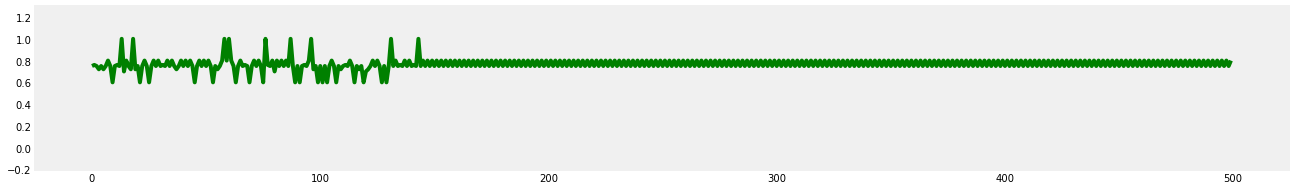

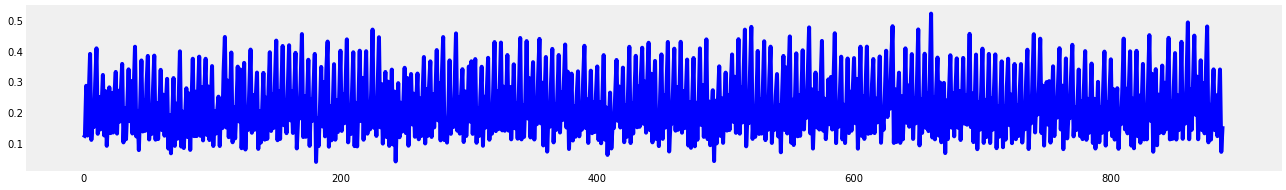

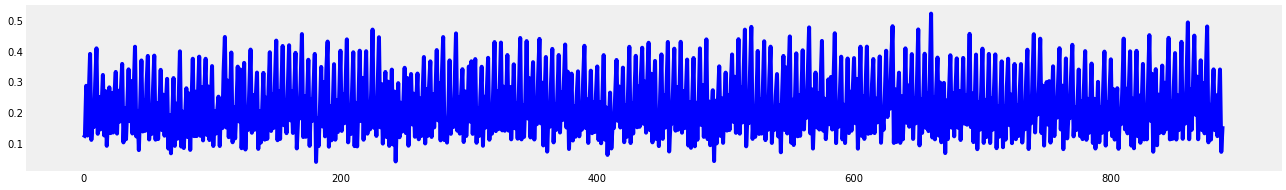

In [18]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(h_fill,'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_actor_loss_l,'b-')
plt.grid()
plt.show()

plt.figure(figsize=(20,3))
plt.plot(avg_critic_loss_l,'b-')
plt.grid()
plt.show()

In [22]:
num_episode = 500
global_step = 0
allow_skip = False
tr_l, h_fill, tr_r, avg_actor_loss_l, avg_critic_loss_l, history_eps, used_boxes_eps = [],[],[],[],[],[],[]
N_MDD = 7
K = 3
n_candidates = 4

boxes_multi1 = [np.array([[20, 20,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20,  4,  4],
         [20, 20,  4],
         [20, 20,  4],
         [20, 20,  4]])]
gt_pos1 = [np.array([[ 0,  0,  0],
         [ 0,  0,  4],
         [ 0,  4,  4],
         [ 0,  8,  4],
         [ 0, 12,  4],
         [ 0, 16,  4],
         [ 0,  0,  8],
         [ 0,  0, 12],
         [ 0,  0, 16]])]

boxes_multi2 = [np.array([[20, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [ 4, 20,  5],
        [10, 20,  5],
        [10, 20,  5],
        [20, 20,  5]])]

gt_pos2 = [np.array([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 4,  0,  5],
        [ 8,  0,  5],
        [12,  0,  5],
        [16,  0,  5],
        [ 0,  0, 10],
        [10,  0, 10],
        [ 0,  0, 15]])]

num_max_boxes = max(len(boxes_multi1[0]), len(boxes_multi2[0]))
num_max_remain = num_max_boxes
print('num_max_boxes',num_max_boxes,'num_max_remain',num_max_remain)

env=Bpp3DEnv()
agent = PPO_Agent(L=20, B=20, H=20, n_remains=num_max_remain, lr=1e-4, exp_steps=900,
                train_st=500, memory_len=1000)

num_max_boxes 9 num_max_remain 9


In [24]:
for e in range(num_episode):
    st=time.time()
    
    if e%2 == 1: 
        boxes_multi,gt_pos = boxes_multi1.copy(), gt_pos1.copy()
    else: 
        boxes_multi,gt_pos = boxes_multi2.copy(), gt_pos2.copy()
    
    env.reset()
    done = False
    step = 0
    
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    next_history, next_load, next_remain_size, next_load_size = [],[],[],[]
    used_boxes, pred_pos = [],[]
    
    boxes_all = np.array(boxes_multi)[0].copy()
    r_boxes = boxes_all.copy()

    while not done:
        state = env.container.copy()
        state_h = env.update_h().copy()
        step += 1
        
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)
        s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c = get_selected_location(s_order, state) 
        loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth, env.height) for s_loc in s_loc_c] ) # 3D -> 2D
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(s_loc_c), r_boxes, num_max_remain, K, loading_size_c, env.height)
        
        s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_state, in_r_boxes, in_loading =\
            get_unique(s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_state, in_r_boxes, in_loading)
        
        if len(s_loc_c) == 1:
            action_idx = 0
        else:
            action_idx = agent.get_action(in_state, loaded_mh_c, in_r_boxes)
        
        env.convert_state(next_cube_c[action_idx]) 
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = loading_size_c[action_idx]
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
        used_boxes = used_boxes + loading_size_c[action_idx]
        pred_pos = pred_pos + loading_pos_c[action_idx]  
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0:
            done = True

        if len(s_loc_c) != 1 or done:
            history.append(in_state[action_idx])
            h_load.append(loaded_mh_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])
            
            next_state = env.container.copy()
            next_state_h = env.container_h.copy() 
            if done:
                in_next_history = next_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2))
                in_next_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_next_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k)
                s_order = get_selected_order(selected, k)
                s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c  =\
                    get_selected_location(s_order, next_state)
                loaded_mh_c = np.array( [get_loaded_mh(s_loc, env.length, env.breadth, env.height) for s_loc in s_loc_c] )
                in_next_history, in_next_remains, in_next_loading =\
                    raw2input(next_state_h, len(s_loc_c), r_boxes, num_max_remain,  K, loading_size_c, env.height)

            s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_next_history, in_next_remains, in_next_loading =\
                get_unique(s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_next_history, in_next_remains, in_next_loading)

            next_history.append(in_next_history)
            next_load.append(loaded_mh_c)
            next_remain_size.append(in_next_remains)
            next_load_size.append(in_next_loading)
                
        if done:
            avg_tr = 0 if len(tr_r)==0 else np.mean(tr_r)
            terminal_reward = env.terminal_reward()
            tr_l.append(terminal_reward)
            h_fill.append(env.terminal_reward())
            tr_r.append(env.terminal_reward())
            
            a_repeate = 6 if env.terminal_reward() ==1.0 else 1
            is_last = False 
            N = len(history)
            for i in range(N):
                if i == N-1: is_last=True
                reward=(0.99**(N-i-1))*terminal_reward
                for a in range(a_repeate):
                    agent.append_sample(history[i], h_load[i], h_remain_size[i], h_load_size[i], reward, is_last,
                                        next_history[i], next_load[i], next_remain_size[i], next_load_size[i])
        
        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            avg_actor_loss_l.append(agent.avg_actor_loss)
            avg_critic_loss_l.append(agent.avg_critic_loss)
    #print(agent.avg_actor_loss)
    log = "=====episode: {:5d} | ".format(e)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "reward(): {:.3f}, {:.3f}| ".format(env.terminal_reward(), terminal_reward)
    log += "avg actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "avg critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

=====episode:     0 | memory length:    18 | reward(): 1.000, 1.000| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 1.371
=====episode:     1 | memory length:    21 | reward(): 0.800, 0.800| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.757
=====episode:     2 | memory length:    24 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.744
=====episode:     3 | memory length:    27 | reward(): 0.800, 0.800| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.594
=====episode:     4 | memory length:    30 | reward(): 0.875, 0.875| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.885
=====episode:     5 | memory length:    33 | reward(): 0.600, 0.600| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.705
=====episode:     6 | memory length:    36 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.879
=====episode:     7 | memory length:    54 | reward(): 1.000, 

=====episode:    62 | memory length:   301 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.710
=====episode:    63 | memory length:   305 | reward(): 0.600, 0.600| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.895
=====episode:    64 | memory length:   308 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.722
=====episode:    65 | memory length:   311 | reward(): 0.800, 0.800| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.728
=====episode:    66 | memory length:   314 | reward(): 0.950, 0.950| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.923
=====episode:    67 | memory length:   317 | reward(): 0.760, 0.760| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.729
=====episode:    68 | memory length:   320 | reward(): 0.750, 0.750| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 0.736
=====episode:    69 | memory length:   323 | reward(): 0.800, 

=====episode:   124 | memory length:   915 | reward(): 1.000, 1.000| avg actor loss : 0.110853 avg critic loss : 0.110853 time: 2.438
=====episode:   125 | memory length:   933 | reward(): 1.000, 1.000| avg actor loss : 0.116553 avg critic loss : 0.116553 time: 1.921
=====episode:   126 | memory length:   951 | reward(): 1.000, 1.000| avg actor loss : 0.097638 avg critic loss : 0.097638 time: 2.454
=====episode:   127 | memory length:   969 | reward(): 1.000, 1.000| avg actor loss : 0.080859 avg critic loss : 0.080859 time: 1.860
=====episode:   128 | memory length:   987 | reward(): 1.000, 1.000| avg actor loss : 0.097455 avg critic loss : 0.097455 time: 2.424
=====episode:   129 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.093765 avg critic loss : 0.093765 time: 1.838
=====episode:   130 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.088778 avg critic loss : 0.088778 time: 2.479
=====episode:   131 | memory length:  1000 | reward(): 1.000, 

=====episode:   186 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.087896 avg critic loss : 0.087896 time: 2.463
=====episode:   187 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.102544 avg critic loss : 0.102544 time: 1.830
=====episode:   188 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.102544 avg critic loss : 0.102544 time: 2.493
=====episode:   189 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.084966 avg critic loss : 0.084966 time: 1.853
=====episode:   190 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.108403 avg critic loss : 0.108403 time: 2.439
=====episode:   191 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.087895 avg critic loss : 0.087895 time: 1.812
=====episode:   192 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.099614 avg critic loss : 0.099614 time: 2.479
=====episode:   193 | memory length:  1000 | reward(): 1.000, 

=====episode:   248 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.084966 avg critic loss : 0.084966 time: 2.427
=====episode:   249 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.093755 avg critic loss : 0.093755 time: 1.858
=====episode:   250 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.108403 avg critic loss : 0.108403 time: 2.409
=====episode:   251 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.102544 avg critic loss : 0.102544 time: 1.884
=====episode:   252 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.111333 avg critic loss : 0.111333 time: 2.451
=====episode:   253 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.105474 avg critic loss : 0.105474 time: 1.889
=====episode:   254 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.084966 avg critic loss : 0.084966 time: 2.486
=====episode:   255 | memory length:  1000 | reward(): 1.000, 

=====episode:   310 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.076178 avg critic loss : 0.076178 time: 2.485
=====episode:   311 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.105474 avg critic loss : 0.105474 time: 1.872
=====episode:   312 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.087896 avg critic loss : 0.087896 time: 2.507
=====episode:   313 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.123051 avg critic loss : 0.123051 time: 1.853
=====episode:   314 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.090825 avg critic loss : 0.090825 time: 2.477
=====episode:   315 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.111333 avg critic loss : 0.111333 time: 1.864
=====episode:   316 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.093755 avg critic loss : 0.093755 time: 2.469
=====episode:   317 | memory length:  1000 | reward(): 1.000, 

=====episode:   372 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.087896 avg critic loss : 0.087896 time: 2.555
=====episode:   373 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.093755 avg critic loss : 0.093755 time: 1.916
=====episode:   374 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.108403 avg critic loss : 0.108403 time: 2.493
=====episode:   375 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.099614 avg critic loss : 0.099614 time: 1.915
=====episode:   376 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.087896 avg critic loss : 0.087896 time: 2.456
=====episode:   377 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.082037 avg critic loss : 0.082037 time: 1.937
=====episode:   378 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.082037 avg critic loss : 0.082037 time: 2.472
=====episode:   379 | memory length:  1000 | reward(): 1.000, 

=====episode:   434 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.082037 avg critic loss : 0.082037 time: 2.511
=====episode:   435 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.099614 avg critic loss : 0.099614 time: 1.889
=====episode:   436 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.087896 avg critic loss : 0.087896 time: 2.451
=====episode:   437 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.108403 avg critic loss : 0.108403 time: 1.899
=====episode:   438 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.102544 avg critic loss : 0.102544 time: 2.449
=====episode:   439 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.099615 avg critic loss : 0.099615 time: 1.894
=====episode:   440 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.090826 avg critic loss : 0.090826 time: 2.425
=====episode:   441 | memory length:  1000 | reward(): 1.000, 

=====episode:   496 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.073248 avg critic loss : 0.073248 time: 2.497
=====episode:   497 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.087896 avg critic loss : 0.087896 time: 1.910
=====episode:   498 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.099614 avg critic loss : 0.099614 time: 2.411
=====episode:   499 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.099615 avg critic loss : 0.099615 time: 1.916


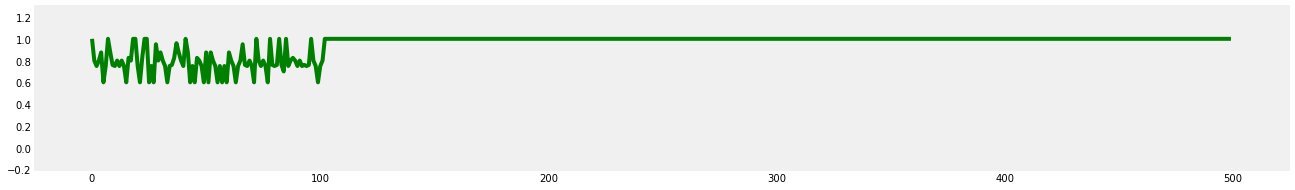

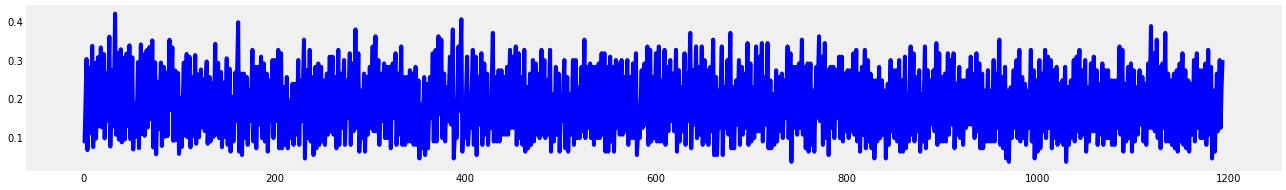

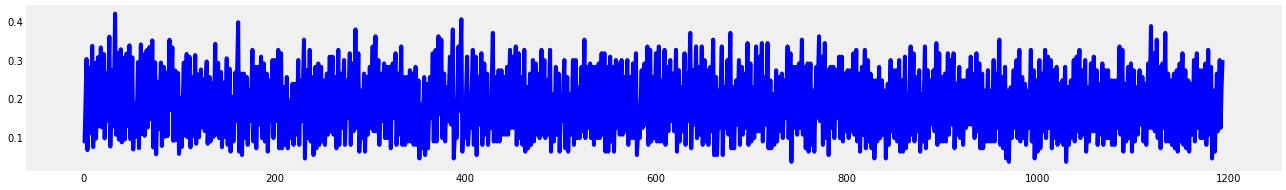

In [25]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(h_fill,'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_actor_loss_l,'b-')
plt.grid()
plt.show()

plt.figure(figsize=(20,3))
plt.plot(avg_critic_loss_l,'b-')
plt.grid()
plt.show()

In [40]:
num_episode = 500
global_step = 0
allow_skip = False
tr_l, h_fill, tr_r, avg_actor_loss_l, avg_critic_loss_l, history_eps, used_boxes_eps = [],[],[],[],[],[],[]
N_MDD = 9
K = 4
n_candidates = 4

boxes, gt_pos = generation_3dbox_random(case_size=[[20,20,20]],min_s=1,
                                        N_mdd = N_MDD)

num_max_boxes = len(boxes[0])
num_max_remain = num_max_boxes# - K
print('num_max_boxes',num_max_boxes,'num_max_remain',num_max_remain)

env=Bpp3DEnv()
agent = PPO_Agent(L=20, B=20, H=20, n_remains=num_max_remain, lr=1e-4, exp_steps=900,
                train_st=500, memory_len=1000)

num_max_boxes 9 num_max_remain 9


In [41]:
for e in range(num_episode):
    st=time.time()
    
    boxes, gt_pos = generation_3dbox_random(case_size=[[20,20,20]],min_s=1,
                                        N_mdd = N_MDD)
    
    env.reset()
    done = False
    step = 0
    
    history, h_load, h_remain_size, h_load_size = [],[],[],[]
    next_history, next_load, next_remain_size, next_load_size = [],[],[],[]
    used_boxes, pred_pos = [],[]
    
    boxes_all = np.array(boxes)[0].copy()
    r_boxes = boxes_all.copy()

    while not done:
        state = env.container.copy()
        state_h = env.update_h().copy()
        step += 1
        
        k = min(K, len(r_boxes))
        selected = cbn_select_boxes(r_boxes[:n_candidates], k)
        s_order = get_selected_order(selected, k)
        s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c = get_selected_location(s_order, state) 
        loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth, env.height) for s_loc in s_loc_c] ) # 3D -> 2D
        in_state, in_r_boxes, in_loading = raw2input(state_h, len(s_loc_c), r_boxes, num_max_remain, K, loading_size_c, env.height)
        
        s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_state, in_r_boxes, in_loading =\
            get_unique(s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_state, in_r_boxes, in_loading)
        
        if len(s_loc_c) == 1:
            action_idx = 0
        else:
            action_idx = agent.get_action(in_state, loaded_mh_c, in_r_boxes)
        
        env.convert_state(next_cube_c[action_idx]) 
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = loading_size_c[action_idx]
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
        used_boxes = used_boxes + loading_size_c[action_idx]
        pred_pos = pred_pos + loading_pos_c[action_idx]  
        if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0:
            done = True

        if len(s_loc_c) != 1 or done:
            history.append(in_state[action_idx])
            h_load.append(loaded_mh_c[action_idx])
            h_remain_size.append(in_r_boxes[action_idx])
            h_load_size.append(in_loading[action_idx])
            
            next_state = env.container.copy()
            next_state_h = env.container_h.copy() 
            if done:
                in_next_history = next_state_h.reshape((1, env.length, env.breadth, 1))
                loaded_mh_c = np.zeros((1, env.length, env.breadth, 2))
                in_next_remains = np.zeros((1, env.length, env.breadth, num_max_remain))
                in_next_loading = np.zeros((1, env.length, env.breadth, K))
            else:
                k = min(K, len(r_boxes))
                selected = cbn_select_boxes(r_boxes[:n_candidates], k)
                s_order = get_selected_order(selected, k)
                s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c  =\
                    get_selected_location(s_order, next_state)
                loaded_mh_c = np.array( [get_loaded_mh(s_loc, env.length, env.breadth, env.height) for s_loc in s_loc_c] )
                in_next_history, in_next_remains, in_next_loading =\
                    raw2input(next_state_h, len(s_loc_c), r_boxes, num_max_remain,  K, loading_size_c, env.height)

            s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_next_history, in_next_remains, in_next_loading =\
                get_unique(s_order, s_loc_c, num_loaded_box_c, loading_size_c, loading_pos_c, next_cube_c , next_state_c, loaded_mh_c, in_next_history, in_next_remains, in_next_loading)

            next_history.append(in_next_history)
            next_load.append(loaded_mh_c)
            next_remain_size.append(in_next_remains)
            next_load_size.append(in_next_loading)
                
        if done:
            avg_tr = 0 if len(tr_r)==0 else np.mean(tr_r)
            terminal_reward = env.terminal_reward()
            tr_l.append(terminal_reward)
            h_fill.append(env.terminal_reward())
            tr_r.append(env.terminal_reward())
            
            a_repeate = 6 if env.terminal_reward() ==1.0 else 1
            is_last = False 
            N = len(history)
            for i in range(N):
                if i == N-1: is_last=True
                reward=(0.99**(N-i-1))*terminal_reward
                for a in range(a_repeate):
                    agent.append_sample(history[i], h_load[i], h_remain_size[i], h_load_size[i], reward, is_last,
                                        next_history[i], next_load[i], next_remain_size[i], next_load_size[i])
        
        if len(agent.memory) >= agent.train_start:
            agent.train_model()
            avg_actor_loss_l.append(agent.avg_actor_loss)
            avg_critic_loss_l.append(agent.avg_critic_loss)
    #print(agent.avg_actor_loss)
    log = "=====episode: {:5d} | ".format(e)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "reward(): {:.3f}, {:.3f}| ".format(env.terminal_reward(), terminal_reward)
    log += "avg actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "avg critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    agent.avg_actor_loss, agent.avg_critic_loss = 0, 0

=====episode:     0 | memory length:     3 | reward(): 0.600, 0.600| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 2.979
=====episode:     1 | memory length:     6 | reward(): 0.890, 0.890| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.669
=====episode:     2 | memory length:    24 | reward(): 1.000, 1.000| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 1.828
=====episode:     3 | memory length:    28 | reward(): 0.573, 0.573| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.495
=====episode:     4 | memory length:    31 | reward(): 0.940, 0.940| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.340
=====episode:     5 | memory length:    34 | reward(): 0.880, 0.880| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.486
=====episode:     6 | memory length:    37 | reward(): 0.780, 0.780| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.492
=====episode:     7 | memory length:    40 | reward(): 0.850, 

=====episode:    62 | memory length:   296 | reward(): 0.720, 0.720| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.376
=====episode:    63 | memory length:   299 | reward(): 0.450, 0.450| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 2.688
=====episode:    64 | memory length:   302 | reward(): 0.200, 0.200| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.182
=====episode:    65 | memory length:   305 | reward(): 0.240, 0.240| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.965
=====episode:    66 | memory length:   308 | reward(): 0.307, 0.307| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 2.488
=====episode:    67 | memory length:   311 | reward(): 0.200, 0.200| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.150
=====episode:    68 | memory length:   323 | reward(): 1.000, 1.000| avg actor loss : 0.000000 avg critic loss : 0.000000 time: 3.401
=====episode:    69 | memory length:   341 | reward(): 1.000, 

=====episode:   124 | memory length:   640 | reward(): 0.325, 0.325| avg actor loss : 0.140832 avg critic loss : 0.140832 time: 4.762
=====episode:   125 | memory length:   643 | reward(): 0.782, 0.782| avg actor loss : 0.115186 avg critic loss : 0.115186 time: 4.134
=====episode:   126 | memory length:   646 | reward(): 0.400, 0.400| avg actor loss : 0.125806 avg critic loss : 0.125806 time: 3.776
=====episode:   127 | memory length:   650 | reward(): 0.400, 0.400| avg actor loss : 0.122975 avg critic loss : 0.122975 time: 4.079
=====episode:   128 | memory length:   652 | reward(): 0.630, 0.630| avg actor loss : 0.104979 avg critic loss : 0.104979 time: 5.322
=====episode:   129 | memory length:   653 | reward(): 0.510, 0.510| avg actor loss : 0.064271 avg critic loss : 0.064271 time: 1.491
=====episode:   130 | memory length:   656 | reward(): 0.750, 0.750| avg actor loss : 0.140923 avg critic loss : 0.140923 time: 4.680
=====episode:   131 | memory length:   659 | reward(): 0.250, 

=====episode:   186 | memory length:   932 | reward(): 1.000, 1.000| avg actor loss : 0.080677 avg critic loss : 0.080677 time: 4.947
=====episode:   187 | memory length:   933 | reward(): 0.836, 0.836| avg actor loss : 0.096434 avg critic loss : 0.096434 time: 1.499
=====episode:   188 | memory length:   951 | reward(): 1.000, 1.000| avg actor loss : 0.125265 avg critic loss : 0.125265 time: 4.769
=====episode:   189 | memory length:   952 | reward(): 0.893, 0.893| avg actor loss : 0.108411 avg critic loss : 0.108411 time: 1.578
=====episode:   190 | memory length:   955 | reward(): 0.988, 0.988| avg actor loss : 0.135313 avg critic loss : 0.135313 time: 5.532
=====episode:   191 | memory length:   973 | reward(): 1.000, 1.000| avg actor loss : 0.118283 avg critic loss : 0.118283 time: 4.595
=====episode:   192 | memory length:   975 | reward(): 0.400, 0.400| avg actor loss : 0.122589 avg critic loss : 0.122589 time: 4.178
=====episode:   193 | memory length:   978 | reward(): 0.958, 

=====episode:   248 | memory length:  1000 | reward(): 0.520, 0.520| avg actor loss : 0.125753 avg critic loss : 0.125753 time: 2.707
=====episode:   249 | memory length:  1000 | reward(): 0.670, 0.670| avg actor loss : 0.102586 avg critic loss : 0.102586 time: 4.947
=====episode:   250 | memory length:  1000 | reward(): 0.900, 0.900| avg actor loss : 0.108799 avg critic loss : 0.108799 time: 3.883
=====episode:   251 | memory length:  1000 | reward(): 0.410, 0.410| avg actor loss : 0.121729 avg critic loss : 0.121729 time: 5.688
=====episode:   252 | memory length:  1000 | reward(): 0.858, 0.858| avg actor loss : 0.108024 avg critic loss : 0.108024 time: 3.325
=====episode:   253 | memory length:  1000 | reward(): 0.350, 0.350| avg actor loss : 0.137951 avg critic loss : 0.137951 time: 5.051
=====episode:   254 | memory length:  1000 | reward(): 0.650, 0.650| avg actor loss : 0.128991 avg critic loss : 0.128991 time: 4.322
=====episode:   255 | memory length:  1000 | reward(): 0.850, 

=====episode:   310 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.132637 avg critic loss : 0.132637 time: 4.577
=====episode:   311 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.132473 avg critic loss : 0.132473 time: 4.849
=====episode:   312 | memory length:  1000 | reward(): 0.588, 0.588| avg actor loss : 0.149764 avg critic loss : 0.149764 time: 4.993
=====episode:   313 | memory length:  1000 | reward(): 0.948, 0.948| avg actor loss : 0.115740 avg critic loss : 0.115740 time: 4.662
=====episode:   314 | memory length:  1000 | reward(): 0.920, 0.920| avg actor loss : 0.108812 avg critic loss : 0.108812 time: 3.801
=====episode:   315 | memory length:  1000 | reward(): 0.254, 0.254| avg actor loss : 0.124437 avg critic loss : 0.124437 time: 4.335
=====episode:   316 | memory length:  1000 | reward(): 0.850, 0.850| avg actor loss : 0.107911 avg critic loss : 0.107911 time: 3.815
=====episode:   317 | memory length:  1000 | reward(): 0.100, 

=====episode:   372 | memory length:  1000 | reward(): 0.100, 0.100| avg actor loss : 0.085206 avg critic loss : 0.085206 time: 3.527
=====episode:   373 | memory length:  1000 | reward(): 0.670, 0.670| avg actor loss : 0.098328 avg critic loss : 0.098328 time: 3.319
=====episode:   374 | memory length:  1000 | reward(): 0.760, 0.760| avg actor loss : 0.110727 avg critic loss : 0.110727 time: 5.271
=====episode:   375 | memory length:  1000 | reward(): 0.965, 0.965| avg actor loss : 0.143249 avg critic loss : 0.143249 time: 4.748
=====episode:   376 | memory length:  1000 | reward(): 0.410, 0.410| avg actor loss : 0.114041 avg critic loss : 0.114041 time: 3.554
=====episode:   377 | memory length:  1000 | reward(): 0.380, 0.380| avg actor loss : 0.121330 avg critic loss : 0.121330 time: 4.369
=====episode:   378 | memory length:  1000 | reward(): 0.995, 0.995| avg actor loss : 0.134466 avg critic loss : 0.134466 time: 3.392
=====episode:   379 | memory length:  1000 | reward(): 0.820, 

=====episode:   434 | memory length:  1000 | reward(): 0.755, 0.755| avg actor loss : 0.151688 avg critic loss : 0.151688 time: 4.900
=====episode:   435 | memory length:  1000 | reward(): 0.100, 0.100| avg actor loss : 0.108171 avg critic loss : 0.108171 time: 5.015
=====episode:   436 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.105342 avg critic loss : 0.105342 time: 4.716
=====episode:   437 | memory length:  1000 | reward(): 0.240, 0.240| avg actor loss : 0.110269 avg critic loss : 0.110269 time: 4.822
=====episode:   438 | memory length:  1000 | reward(): 0.600, 0.600| avg actor loss : 0.135169 avg critic loss : 0.135169 time: 3.615
=====episode:   439 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.108400 avg critic loss : 0.108400 time: 4.679
=====episode:   440 | memory length:  1000 | reward(): 0.715, 0.715| avg actor loss : 0.101388 avg critic loss : 0.101388 time: 4.551
=====episode:   441 | memory length:  1000 | reward(): 0.835, 

=====episode:   496 | memory length:  1000 | reward(): 0.490, 0.490| avg actor loss : 0.127535 avg critic loss : 0.127535 time: 5.093
=====episode:   497 | memory length:  1000 | reward(): 1.000, 1.000| avg actor loss : 0.126187 avg critic loss : 0.126187 time: 4.704
=====episode:   498 | memory length:  1000 | reward(): 0.480, 0.480| avg actor loss : 0.123079 avg critic loss : 0.123079 time: 5.115
=====episode:   499 | memory length:  1000 | reward(): 0.300, 0.300| avg actor loss : 0.134666 avg critic loss : 0.134666 time: 4.458


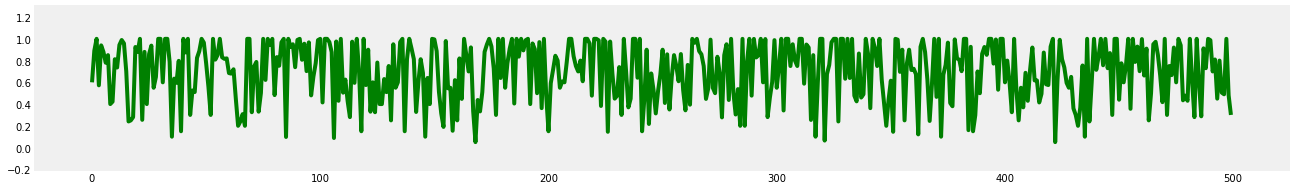

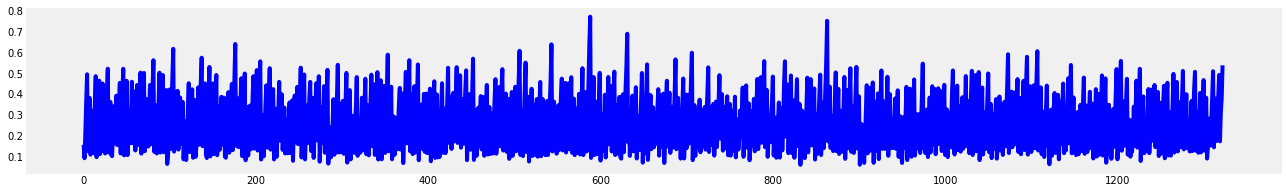

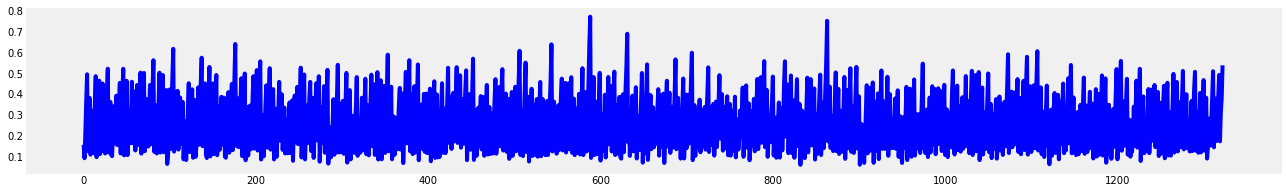

In [42]:
%matplotlib inline

plt.figure(figsize=(20,3))
plt.plot(h_fill,'g-')
plt.ylim(-0.2,1.3)
plt.grid()

plt.figure(figsize=(20,3))
plt.plot(avg_actor_loss_l,'b-')
plt.grid()
plt.show()

plt.figure(figsize=(20,3))
plt.plot(avg_critic_loss_l,'b-')
plt.grid()
plt.show()

In [ ]:
class PPO_Agent():
    def __init__(self, L=20, B=20, H=20, n_remains=5, lr=1e-8, exp_steps=500,
                train_st = 200, memory_len = 500):
        self.state_size = (L,B,1)
        self.selected_size = (L,B,2)
        self.remain_size = (L,B,n_remains)
        self.output_size = 1
        
        self.discount_factor = 0.99
        self.learning_rate = lr #1e-8 #1e-4
        self.exploration_steps = exp_steps
        self.batch_size = 32
        self.train_start = train_st
        self.beta = 0.2
        self.clip_pram = 0.2
        self.memory = deque(maxlen=memory_len)
        self.gamma = 0.9
        self.actor = Actor(self.state_size, self.selected_size, self.remain_size, self.output_size)
        self.critic = Critic(self.state_size, self.selected_size, self.remain_size, self.output_size)
        self.actor_optimizer = Adam(self.learning_rate)
        self.critic_optimizer = Adam(self.learning_rate)
        self.avg_actor_loss = 0
        self.avg_critic_loss = 0
        
    def get_action(self, state, loaded_mh_c, r_boxes):
        if len(self.memory) < self.train_start:
            random_action = random.randrange(len(state))
            return random_action
        else:
            q_values = self.actor([state, loaded_mh_c, r_boxes])
            argmax_idx = np.where(q_values == tf.math.reduce_max(q_values))
            action_idx = argmax_idx[0][0]
            return action_idx
        
    def append_sample(self, history, load, remain_size, load_size, reward, last, next_history, next_load, next_remain_size, next_load_size):
        self.memory.append(( history, load, remain_size, load_size, reward, last, next_history, next_load, next_remain_size, next_load_size))
        
    def actor_loss_temp(self, probs, actions, adv, old_probs, closs):
        probability = probs
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability, tf.math.log(probability))))
        sur1 = []
        sur2 = []
        
        for pb, t, op in zip(probability, adv, old_probs):
            t = tf.constant(t)
            op = tf.constant(op)
            ratio = tf.math.divide(pb, op)
            s1 = tf.math.multiply(ratio, t)
            s2 = tf.math.multiply(tf.clip_by_value(ratio, 1.0-self.clip_pram, 1.0 + self.clip_pram), t)
            sur1.append(s1)
            sur2.append(s2)
        
        sr1 = tf.stack(sur1)
        sr2 = tf.stack(sur2)
        
        loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) - closs + 0.001 * entropy)
        return loss
    
    def get_actor_loss(self, discnt_rewards, a):
        err = tf.abs(discnt_rewards - a)
        quad = tf.clip_by_value(err, 0.0, 1.0)
        linear = err - quad
        loss = tf.reduce_mean(0.5 * tf.square(quad) + linear)
        return loss
        
        #return 0.5 * kls.mean_squared_error(discnt_rewards, a)
    
    def get_critic_loss(self, discnt_rewards, v):
        err = tf.abs(discnt_rewards - v)
        quad = tf.clip_by_value(err, 0.0, 1.0)
        linear = err - quad
        loss = tf.reduce_mean(0.5 * tf.square(quad) + linear)
        return loss
        #return 0.5 * kls.mean_squared_error(discnt_rewards, v)
    
    def train_model(self):
        batch = random.sample(self.memory, self.batch_size)
        
        history = np.array([sample[0] for sample in batch])
        load = np.array([sample[1] for sample in batch])
        remain_size = np.array([sample[2] for sample in batch])
        load_size = np.array([sample[3] for sample in batch])
        reward = np.array([sample[4] for sample in batch])
        dones = np.array([sample[5] for sample in batch])
        next_history = [sample[6] for sample in batch] 
        next_load = [sample[7] for sample in batch]
        next_remain_size = [sample[8] for sample in batch] 
        next_load_size = [sample[9] for sample in batch] 
        
        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            actor = self.actor([history, load, remain_size])
            value = self.critic([history, load, remain_size])
            targets = []
            for i in range(self.batch_size):
                next_value = agent.critic([next_history[i], next_load[i], next_remain_size[i]])
                t_max_q = tf.math.reduce_max(next_value)
                t = [(1- 0.75)*reward[i] + (1 - dones[i]) *0.75*t_max_q]
                targets.append(t)
            actor_loss = self.get_actor_loss(targets, actor)
            critic_loss = self.get_critic_loss(targets, value)
            self.avg_actor_loss += actor_loss.numpy()
            self.avg_critic_loss += critic_loss.numpy()
                
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))